In [1]:
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.integrate import odeint
import sys
current_dir = os.path.dirname(os.getcwd())
target_dir = os.path.sep.join(current_dir.split(os.path.sep)[:])
sys.path.append(os.path.join(os.path.dirname(target_dir),'eABCSMC'))
sys.path.append(target_dir)
from Utils.Models import *
from Utils.EABCSMC import *
from Utils.Preconditioning import *
import time



In [3]:
italy = pd.read_csv('../Data/Sird_bigdata.csv')
italy.fillna(0, inplace = True)

Precond = Preconditioner(SIRD_reduced_30_new)

Precond.preprocess_data(data=italy, start=0, eff=30, ext=150)

In [4]:
popt, pcov = Precond.fit(p0 = (0.1, 0.1, 10, 0.1), bounds=([0, 0, 0, 0], [3, 7, 200, 3]))

In [117]:
lambda_ranges = [lambda: npr.uniform(low = 0.5, high = 5), lambda: npr.uniform(low = 0.5, high = 5), lambda: npr.uniform(low = 0.5, high = 5),
                 lambda: npr.uniform(low = 10, high = 20)]
prior_means =  np.array([ 0.28802481,  0.03922435,  10,  0.06892933])

Sampler = EABCSMCSampler(true_y = Precond.true_yy, ODEmodel = Precond.fit_odeint, num_param = len(popt), numerical_estimate = popt, final_time = 30, 
                         lambda_ranges = lambda_ranges, prior_means = prior_means, n_jobs = 4)

  0%|                                                                                        | 0/30000 [00:00<?, ?it/s]

Borders estimation start...


  0%|▏                                                                             | 36/15000 [00:00<00:56, 264.76it/s]

Acceptance rate:  0.005733333333333333
Borders estimation completed, starting preprocessing...
Borders: [0.3469506390161159, 0.0028818140389969167, 3.4561399571494547, 0.0766759174720517]


  0%|                                                                              | 24/15000 [00:00<01:33, 159.64it/s]

Acceptance rate:  0.0034666666666666665
Preprocessing completed, starting ABC-SMC


  0%|▏                                                                             | 36/15000 [00:00<00:52, 285.22it/s]

Acceptance rate:  0.024466666666666668
ABS-SMC round :  2


  0%|                                                                             | 36/120000 [00:00<08:42, 229.62it/s]

Acceptance rate:  0.0166
ABS-SMC round :  3


100%|█████████████████████████████████████████████████████████████████████████| 120000/120000 [03:36<00:00, 554.33it/s]


Acceptance rate:  0.007333333333333333


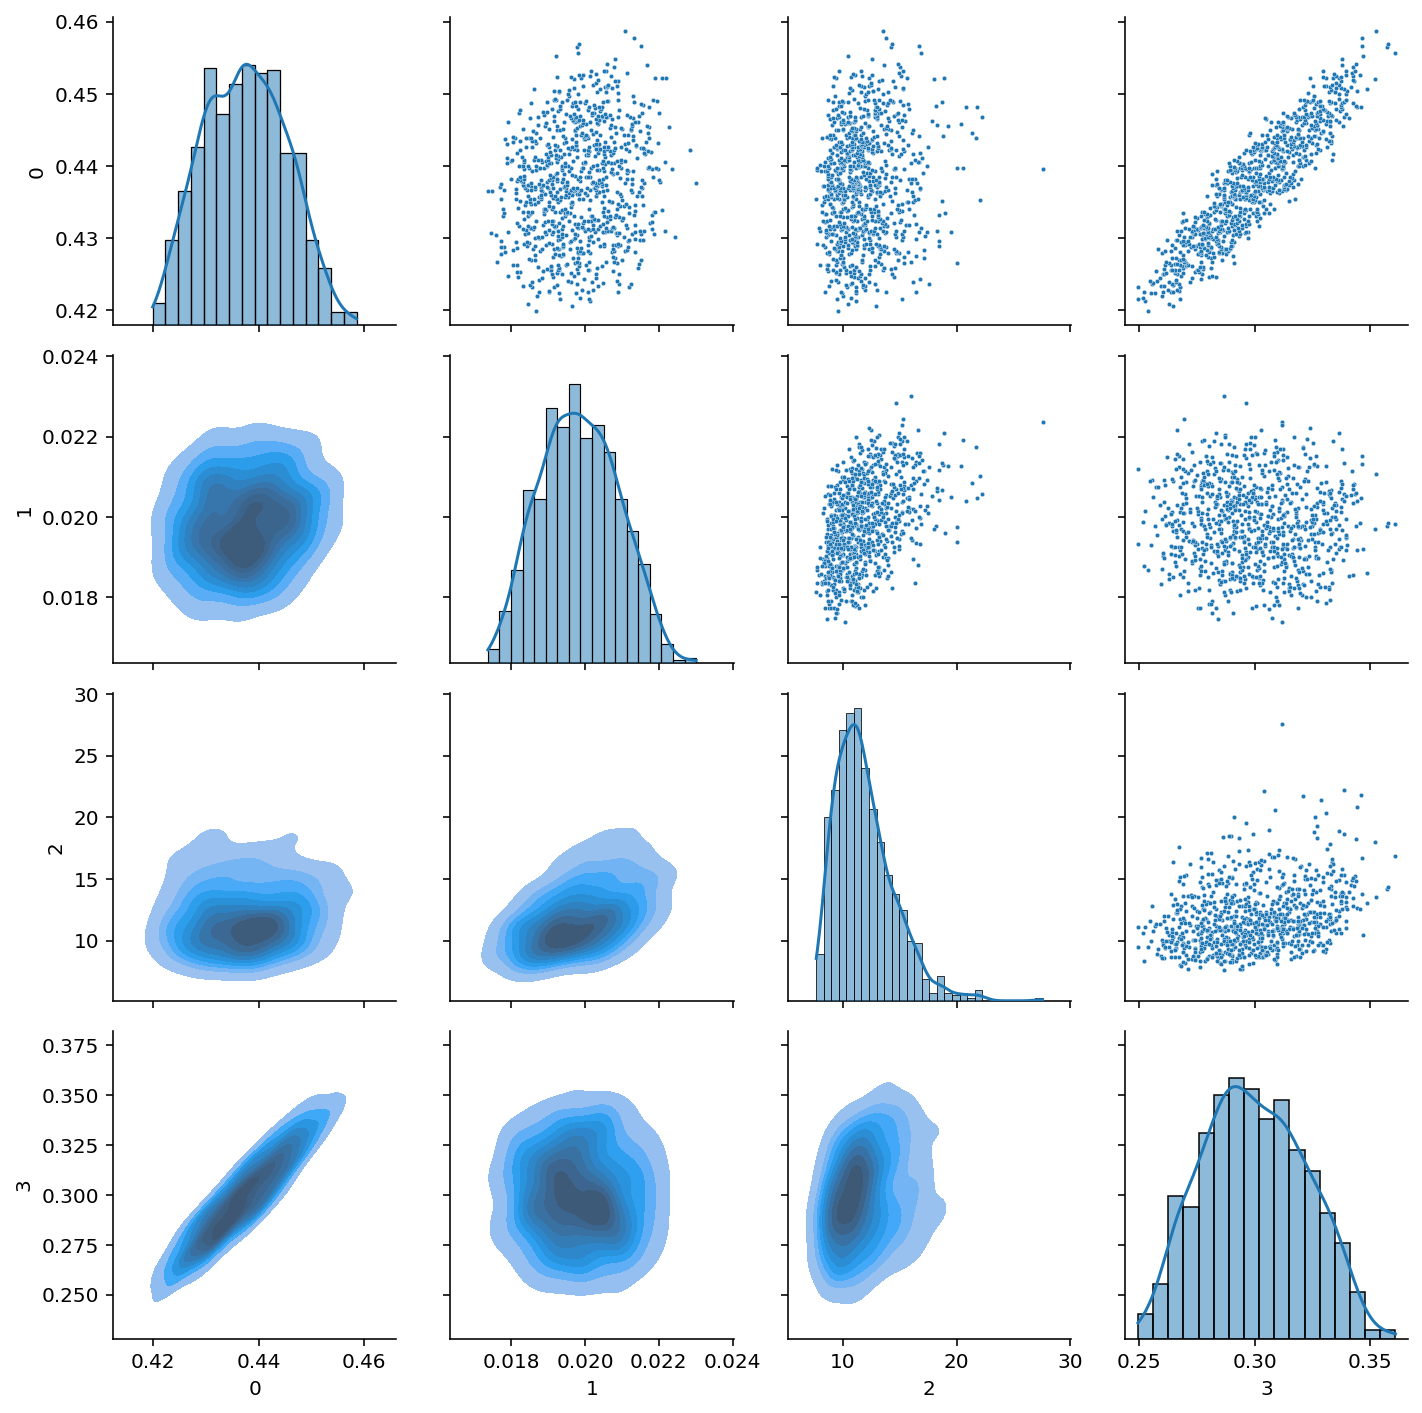

In [118]:
Sampler.fit(niters=3000, eps_schedule=[2, 1, 1/2, 1/4, 1/8], niters_schedule=[10, 5, 5, 5, 40])
Sampler.pairplot()

In [120]:
parameters = Sampler.parameters

In [16]:
def plot_traj_SIRD(trajectories, width=1.5):
    x2 = trajectories[:, 0]
    x3 = trajectories[:, 1]
    x4 = trajectories[:, 2]

    i = plt.plot(x2, linewidth=width, label='Infected', color = 'navy')
    r = plt.plot(x3, linewidth=width, label='Recovered', color = (.21,.39,.55))
    d = plt.plot(x4, linewidth=width, label='Deceased', color = (0.39,.72,1))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.title('Real SIRD')
    plt.title('SIRD prediction at day 30')
    plt.tight_layout()
    
def plot_traj_SIRD2(trajectories, width=.7):
    x2 = trajectories[:, 0]
    x3 = trajectories[:, 1]
    x4 = trajectories[:, 2]
    color_ = (0,0,0.5)
    

    i = plt.plot(x2, linewidth=width,color = 'navy', linestyle = 'dashed' )
    r = plt.plot(x3, linewidth=width, color = (.21,.39,.55), linestyle = 'dashed')
    d = plt.plot(x4, linewidth=width,  color = (0.39,.72,1), linestyle = 'dashed')

    # plt.title('Real SIRD')
    plt.tight_layout()

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 234.75it/s]


103642.35819379898 141131.5024127625
52.475 58.0
55
108257.0


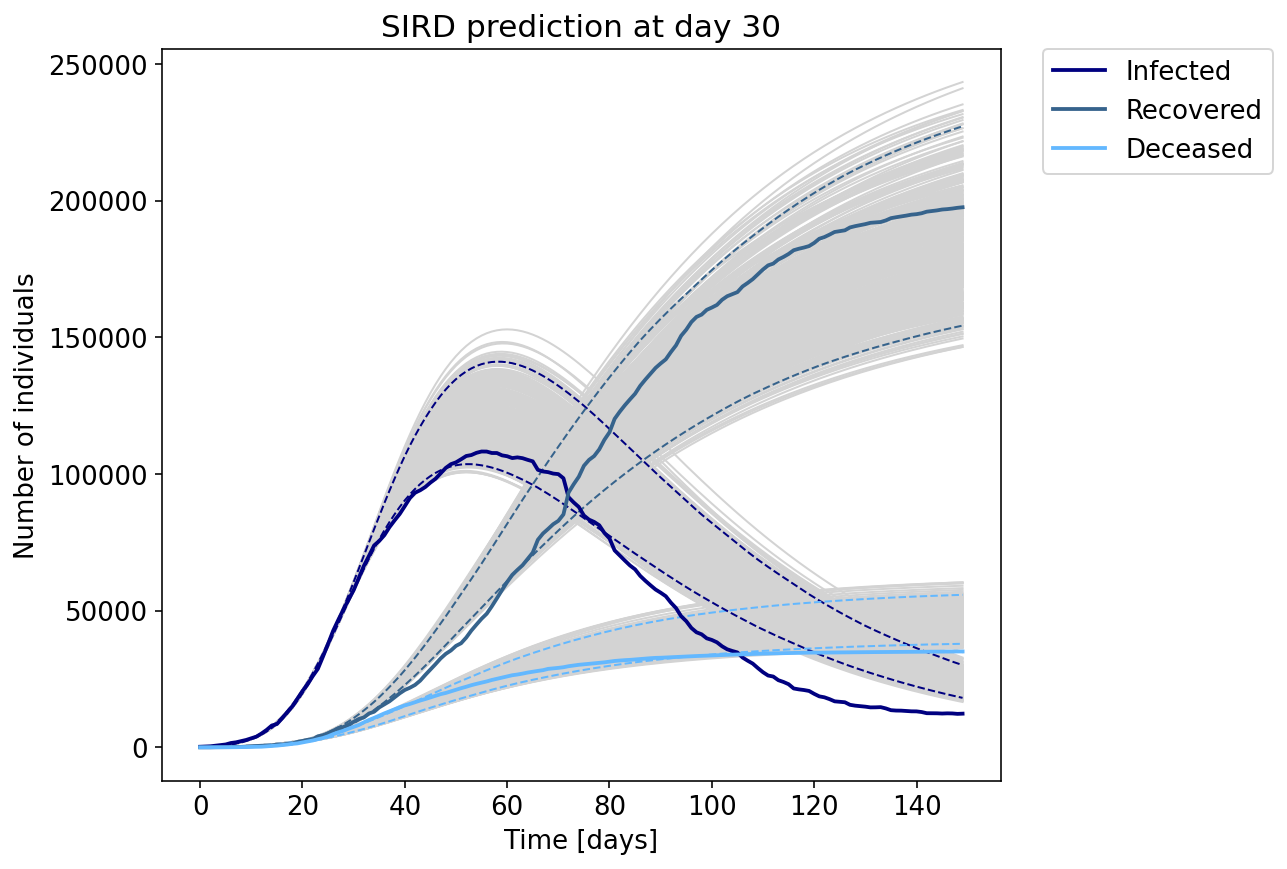

<Figure size 432x288 with 0 Axes>

In [37]:
# magari anche questo lo metto dentro all'abc sampler

fig = plt.figure(figsize = (9,6))

plt.rcParams.update({'font.size': 13})

peak = []
day_peak = []
simul_all = []

for j in tqdm(range(parameters.shape[0])):
    simul_yy =  odeint(SIRD_reduced_30_new, [221,1,7], np.arange(150), args=tuple(parameters[j]))
    simul_all.append(simul_yy)
    plot_traj_gray_SIRD(simul_yy)
    peak.append(max(simul_yy[:,0]))
    day_peak.append(np.argmax(simul_yy[:,0])) 

simul_all = np.array(simul_all)
q95 = []
q05 = []
mean = []
sd = []
for i in range(150):
    q95.append([np.quantile(simul_all[:,i,0],0.975),np.quantile(simul_all[:,i,1],0.975),np.quantile(simul_all[:,i,2],0.975)])
    q05.append([np.quantile(simul_all[:,i,0],0.025),np.quantile(simul_all[:,i,1],0.025),np.quantile(simul_all[:,i,2],0.025)])
    mean.append([np.mean(simul_all[:,i,0]),np.mean(simul_all[:,i,1]),np.mean(simul_all[:,i,2])])
    sd.append([np.std(simul_all[:,i,0]),np.std(simul_all[:,i,1]),np.std(simul_all[:,i,2])])

q95 = np.array(q95)    
q05 = np.array(q05)   
    
plot_traj_SIRD2(q95)

plot_traj_SIRD2(q05)

plot_traj_SIRD(Precond.extended_y)

print(np.quantile(peak,0.025), np.quantile(peak,0.975))
print(np.quantile(day_peak,0.025), np.quantile(day_peak,0.975))
print(np.argmax(Precond.extended_y[:,0]))
print(np.max(Precond.extended_y[:,0]))

plt.ylabel('Number of individuals')
plt.xlabel('Time [days]')
plt.show()


In [199]:
PBR = 0
for i in range(31,150):
    PBR += np.sum([(Precond.extended_y[i][j] - mean[i][j] / sd[i][j])**2 for j in range(2)])

In [200]:
PBR

2825480187584.038

10 11


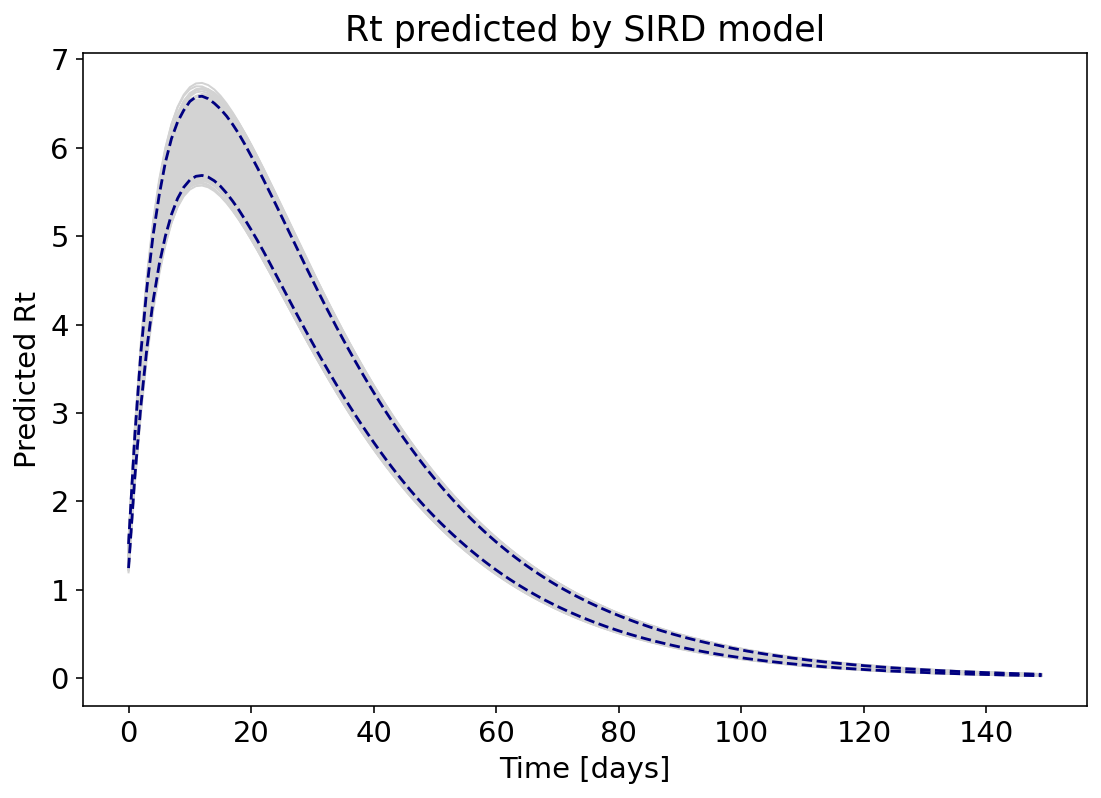

<Figure size 432x288 with 0 Axes>

In [49]:
t = np.arange(150)

fig = plt.figure(figsize = (9,6))
plt.rcParams.update({'font.size': 14.5})

day_max = []
rt = []
for j in range(parameters.shape[0]):
    rt.append(parameters[j,0]* np.exp(-(9.72588371e-02 * parameters[j,0]) * t)/((parameters[j,3]/(t+1)) + parameters[j,1]))
    plt.plot(t, parameters[j,0]* np.exp(-(9.72588371e-02 * parameters[j,0]) * t)/((parameters[j,3]/(t+1)) + parameters[j,1]), linewidth = 1, color = 'lightgray')
    day_max.append(np.argmax(parameters[j,0]* np.exp(-(1.713e-2 + 7.094e-02 * parameters[j,0]) * t)/((parameters[j,3]/(t+1)) + parameters[j,1])))

rt = np.array(rt)

rt95 = []
rt05 = []
for i in range(150):
    rt95.append(np.quantile(rt[:,i],0.975))
    rt05.append(np.quantile(rt[:,i],0.025))
    
plt.plot(rt95, linewidth=1.4,color = 'navy', linestyle = 'dashed')
plt.plot(rt05, linewidth=1.4,color = 'navy', linestyle = 'dashed')

print(min(day_max), max(day_max))  
plt.title('Rt predicted by SIRD model')
plt.ylabel('Predicted Rt')
plt.xlabel('Time [days]')
plt.figure();

In [ ]:
bigtimes = []
for j in range(10):
    times = []
    for i in range(6):
        time_in = time.time()
        Sampler = EABCSMCSampler(true_y = Precond.true_yy, ODEmodel = Precond.fit_odeint, num_param = len(popt), numerical_estimate = popt, final_time = 30, 
                                 lambda_ranges = lambda_ranges, prior_means = prior_means, n_jobs = i+1, verbose = False)
        time_in = time.time()
        Sampler.fit(niters=3000, eps_schedule=[2, 1, 1/2, 1/4, 1/8], niters_schedule=[10, 5, 5, 5, 10])
        times.append(time.time() - time_in)
        #Sampler.pairplot()
    bigtimes.append(times)
        
    
    

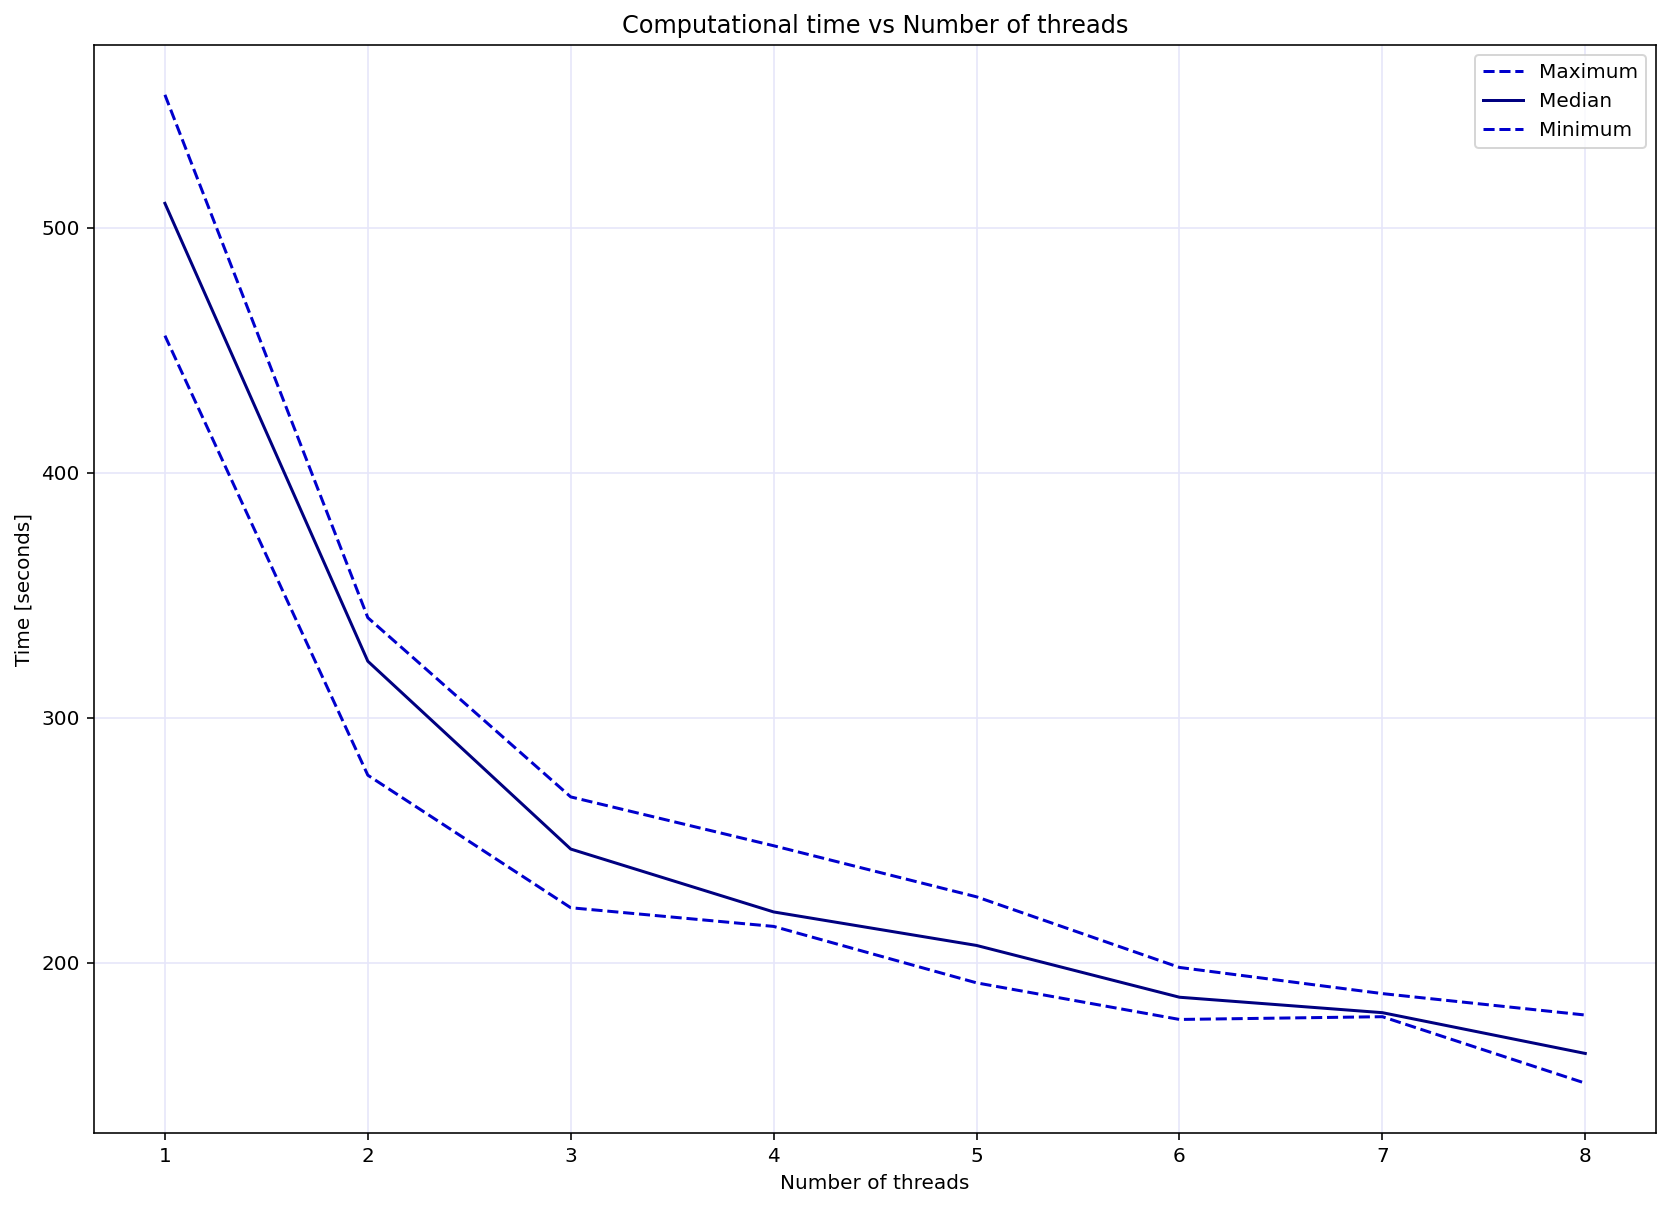

In [71]:
fig = plt.figure(figsize = (14,10))
ax = fig.gca()
ax.set_xticks(np.arange(1,9,1))
ax.set_yticks(np.arange(100,700, 100))

plt.title('Computational time vs Number of threads')
plt.xlabel('Number of threads')
plt.ylabel('Time [seconds]')

plt.grid(color = 'lavender')

plt.plot(np.arange(1,9),np.sort(bg, axis = 0)[-2], color = 'mediumblue', linestyle = 'dashed', label = 'Maximum')
plt.plot(np.arange(1,9),np.median(bg, axis = 0), color = 'navy', label = 'Median')
plt.plot(np.arange(1,9),np.sort(bg, axis = 0)[1],  color = 'mediumblue', linestyle = 'dashed', label = 'Minimum')
plt.legend() ;